In [1]:
import numpy as np

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
sns.set(style='ticks', context='notebook', palette='colorblind', font='serif')

import utils
plt.rcParams.update(utils.rcParams)

from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde as Bounded_1d_kde

In [2]:
# A list of events
event_list = ["S190519bj", "S190521r", "S190630ag", "S190828j", \
              "S190910s", "GW150914", "GW170104", "GW170729"]

# Color for each event
color_dict = {
    "S190519bj": sns.color_palette("Set1", desat=0.7)[0],
    "S190521r": sns.color_palette("Set1", desat=0.7)[0],
    "S190630ag": sns.color_palette("Set1", desat=0.7)[0],
    "S190828j": sns.color_palette("Set1", desat=0.7)[0],    
    "S190910s": sns.color_palette("Set1", desat=0.7)[0],
    "GW150914": sns.color_palette("Set1", desat=0.7)[0],
    "GW170104": sns.color_palette("Set1", desat=0.7)[0],
    "GW170729": sns.color_palette("Set1", desat=0.7)[0]
}
alpha = 0.2

# Prior used for each event
prior_dict = {
    "dtau_220-min": {"S190519bj": -0.8, "S190521r": -0.8, "S190630ag": -0.8, "S190828j": -0.8, "S190910s": -0.8, "GW150914": -0.8, "GW170104": -0.8, "GW170729": -0.8 },
    "dtau_220-max": {"S190519bj": 1.5, "S190521r": 1.5, "S190630ag": 1.5, "S190828j": 1.5, "S190910s": 3.0, "GW150914": 1.0, "GW170104": 1.5, "GW170729": 1.5},
    "domega_220-min": {"S190519bj": -0.8, "S190521r": -0.8, "S190630ag": -0.8, "S190828j": -0.8, "S190910s": -0.8, "GW150914": -0.8, "GW170104": -0.8, "GW170729": -0.8},
    "domega_220-max": {"S190519bj": 2.0, "S190521r": 1.0, "S190630ag": 1.0, "S190828j": 1.0, "S190910s": 1.0, "GW150914": 1.0, "GW170104": 1.0, "GW170729": 1.0}
}

data_file_path_template = "{event}/rin_{event}_pseobnrv4hm_{param}.dat.gz"

# Parameters to be visualized
params = ["domega_220", "dtau_220"]

/Users/abhirupghosh/Documents/Work/spinqnm/data/rin/utils.py:831: UserWarning: linewidths is ignored by contourf
  ax.contourf(XS, YS, ZS, levels=l, **kwargs)


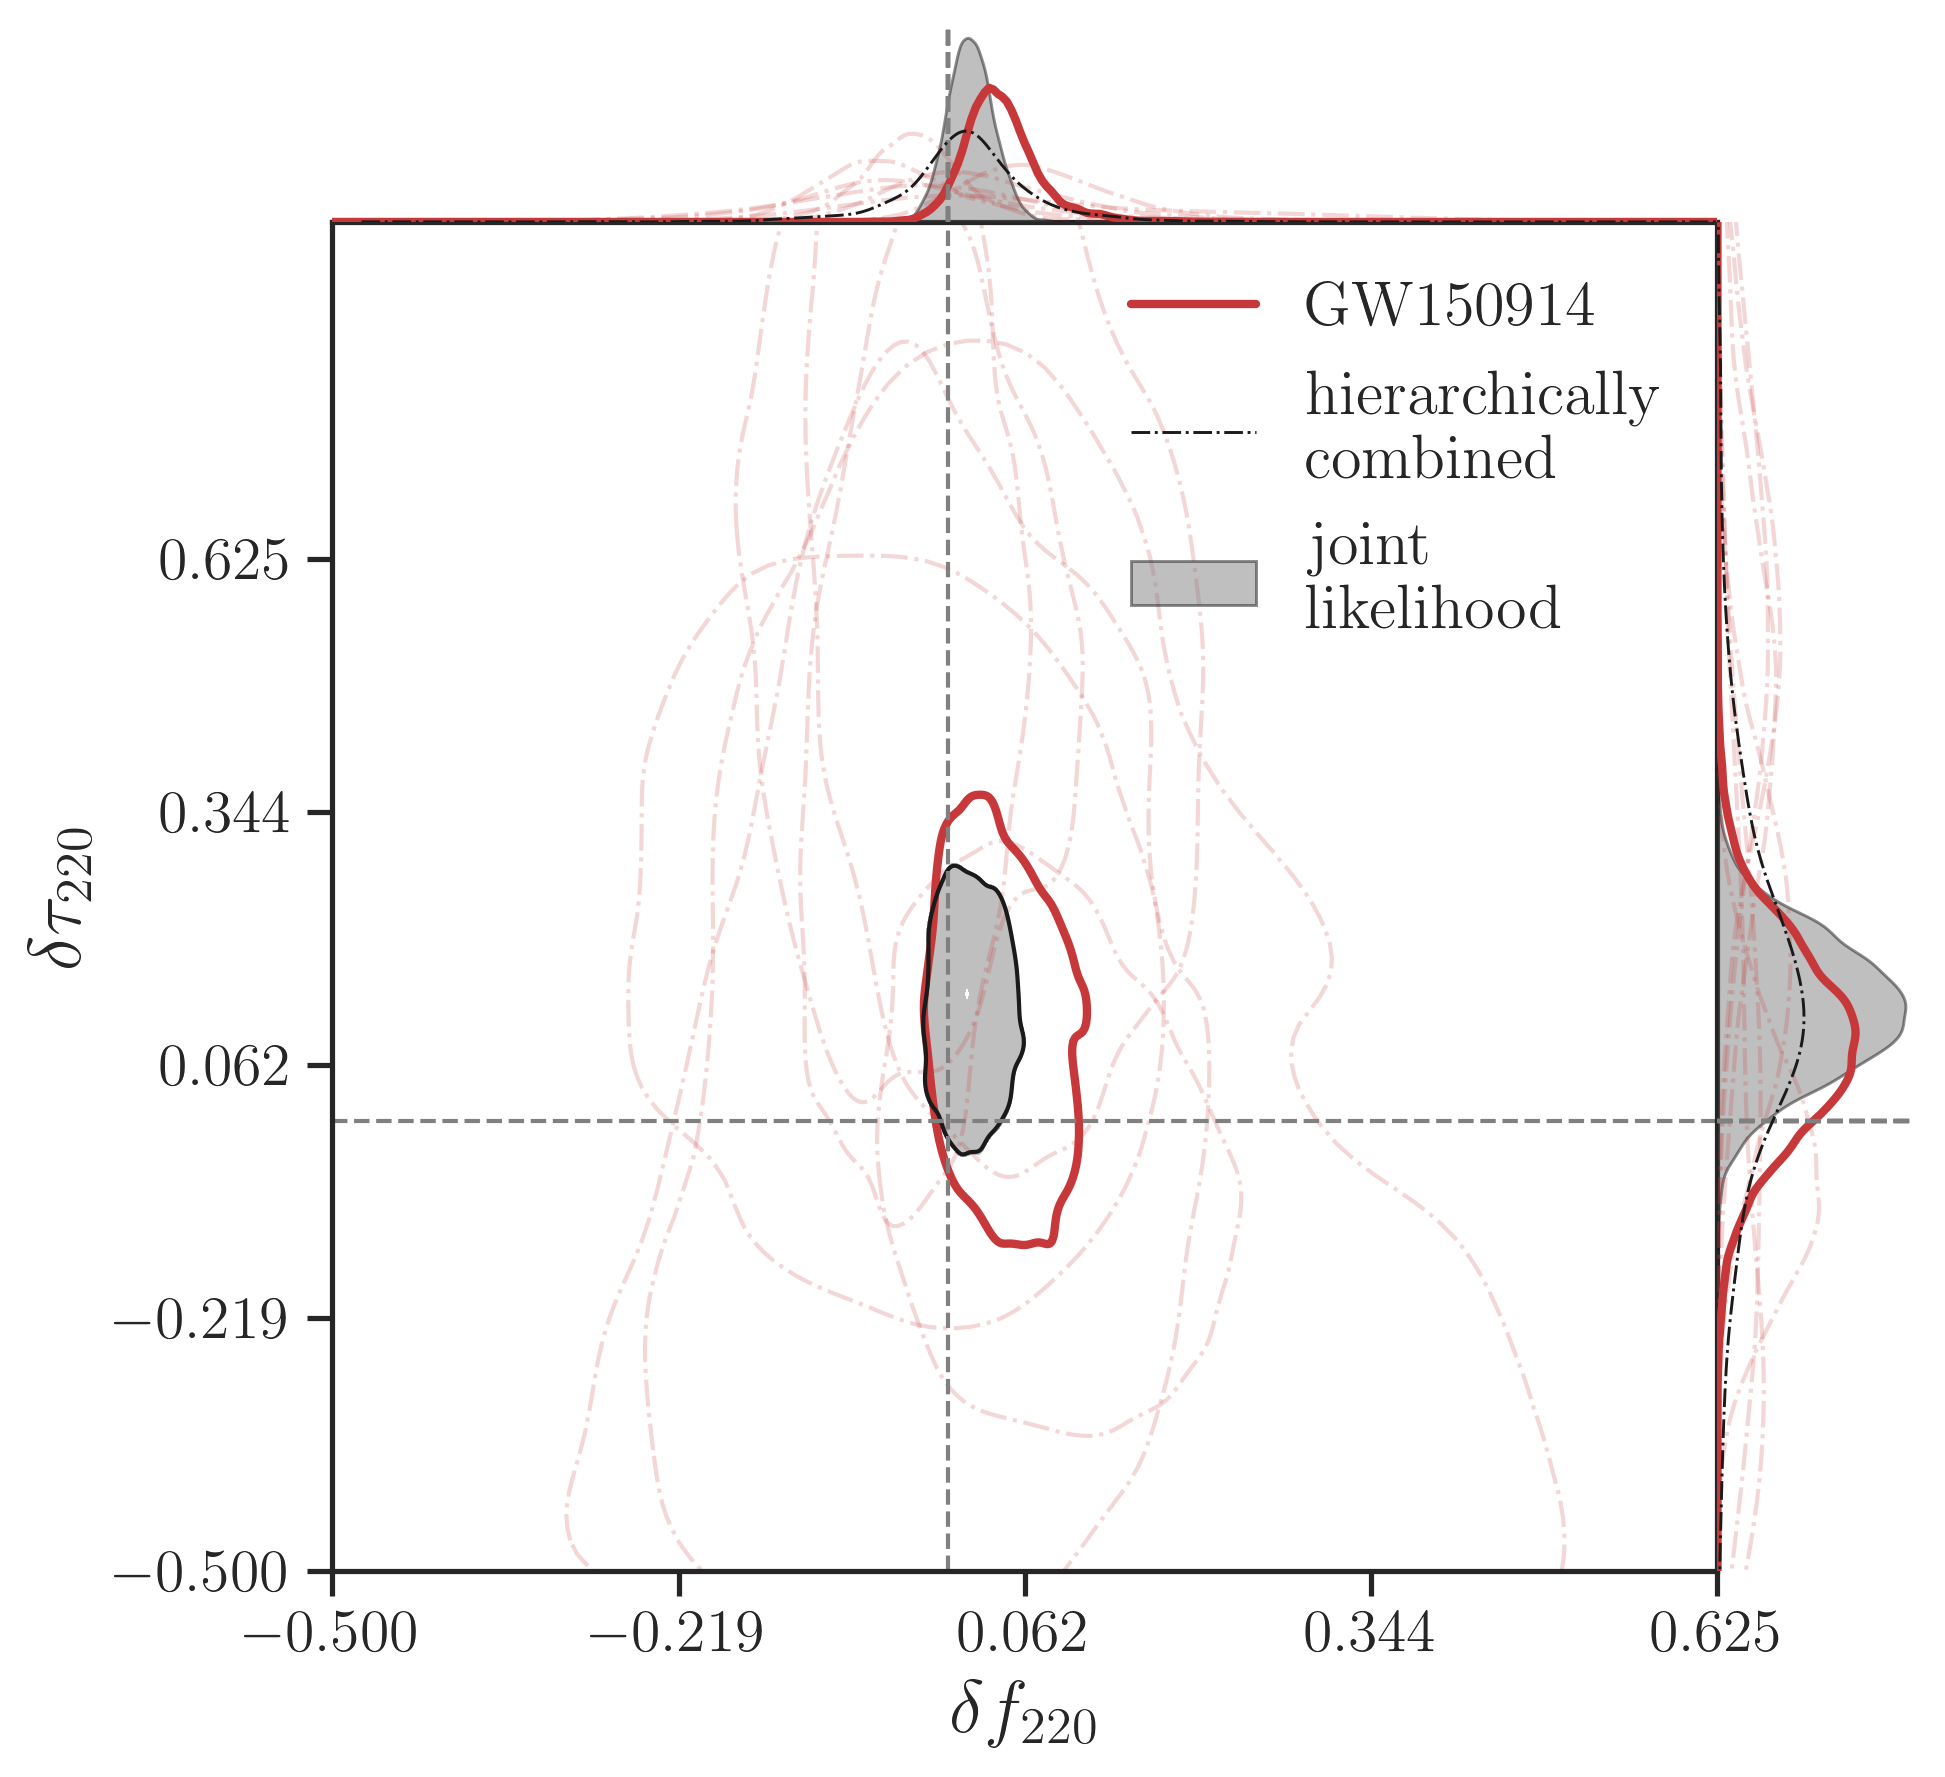

In [21]:
def kde_helper(samples, xlow=None, xhigh=None):
    # Initialize bounded KDE
    if xlow is None:
        xlow = np.amin(samples)
    if xhigh is None:
        xhigh = np.amax(samples)
    kde = Bounded_1d_kde(samples, xlow=xlow, xhigh=xhigh)
    pts = np.linspace(xlow, xhigh, num=500)
    pdf = kde(pts)
    
    return pts, pdf

# Load samples first
sample_dict = {}
for param in params:
    sample_dict[param] = {}
    for event in event_list:
        sample_dict[param][event] = np.loadtxt(data_file_path_template.format(event=event, param=param))

# Tune the min and max params
df_220_min = -0.5
df_220_max = 0.625
dtau_220_min = -0.5
dtau_220_max = 1.
tick_pos = np.linspace(df_220_min, df_220_max, num=5)

fig = plt.figure(dpi=150, figsize=utils.figsize_square) # Make a square plot
gs = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[7,1], height_ratios=[1,7])
# Tune the plot settings
ax_joint = fig.add_subplot(gs[1,0])
ax_joint.set_xlabel(r"$\delta f_{220}$")
ax_joint.set_ylabel(r"$\delta \tau_{220}$")
ax_joint.set_xticks(tick_pos)
ax_joint.set_yticks(tick_pos)
linewidth = 1

ax_df_220 = fig.add_subplot(gs[0,0], sharex=ax_joint)
plt.setp(ax_df_220.get_xticklabels(), visible=False)
plt.setp(ax_df_220.get_yticklabels(), visible=False)
ax_dtau_220 = fig.add_subplot(gs[1,1], sharey=ax_joint)
plt.setp(ax_dtau_220.get_xticklabels(), visible=False)
plt.setp(ax_dtau_220.get_yticklabels(), visible=False)
plt.subplots_adjust(hspace=0.,wspace=0.)

for event in event_list:
    e = utils.Event(event)

    # Plot domega220 first
    pts, pdf = kde_helper(sample_dict["domega_220"][event], xlow=prior_dict["domega_220-min"][event], xhigh=prior_dict["domega_220-max"][event])
    if event == "GW150914":
        ax_df_220.plot(pts, pdf, linewidth=2.0, color=color_dict[event], label=e.name)
    else:
        ax_df_220.plot(pts, pdf, linewidth=linewidth, color=color_dict[event], alpha=alpha, linestyle='dashdot')
    ax_df_220.axvline(0, ls="--", c="grey", linewidth=linewidth)
    
    # Plot dtau220 next
    pts, pdf = kde_helper(sample_dict["dtau_220"][event], xlow=prior_dict["dtau_220-min"][event], xhigh=prior_dict["dtau_220-max"][event])
    if event == "GW150914":
        ax_dtau_220.plot(pdf, pts, linewidth=2.0, color=color_dict[event])
    else:
        ax_dtau_220.plot(pdf, pts, linewidth=linewidth, color=color_dict[event], alpha=alpha, linestyle='dashdot')
    ax_dtau_220.axhline(0, ls="--", c="grey", linewidth=linewidth)
    
    # Plot the joint distribution (with 90% contour) at last using utils.kdeplot_2d_clevels
    # We fix the random seed here for consistency
    np.random.seed(190521)
    # Reduce the number of samples used to train the Gaussian KDE for speed
    choice = np.random.choice(len(sample_dict["domega_220"][event]), size=5000)
    x_train = sample_dict["domega_220"][event][choice]
    y_train = sample_dict["dtau_220"][event][choice]
    # The bounded and unbounded 2D KDE look the same. Use bounded_2d_kde anyway
    if event == "GW150914":
        utils.kdeplot_2d_clevels(x_train, y_train, levels=[0.90], xlow=prior_dict["domega_220-min"][event], xhigh=prior_dict["domega_220-max"][event], ylow=prior_dict["dtau_220-min"][event], yhigh=prior_dict["dtau_220-max"][event], ax=ax_joint, linewidths=[2.0], colors=[color_dict[event]])
    else:
        utils.kdeplot_2d_clevels(x_train, y_train, levels=[0.90], xlow=prior_dict["domega_220-min"][event], xhigh=prior_dict["domega_220-max"][event], ylow=prior_dict["dtau_220-min"][event], yhigh=prior_dict["dtau_220-max"][event], ax=ax_joint, linewidths=[linewidth], colors=[color_dict[event]], alpha=alpha, linestyles=['dashdot'])
        
ax_joint.axvline(0, ls="--", c="grey", linewidth=linewidth)
ax_joint.axhline(0, ls="--", c="grey", linewidth=linewidth)


# Plot the hierarchical results
domega220_hier = np.loadtxt("combined_samples/{param}_pop.dat.gz".format(param="domega_220"))
dtau220_hier = np.loadtxt("combined_samples/{param}_pop.dat.gz".format(param="dtau_220"))

# Plot the hierarchical results
# domega_220
df_220_hier_pts, df_220_hier_pdf = kde_helper(domega220_hier)
ax_df_220.plot(df_220_hier_pts, df_220_hier_pdf, linewidth=0.7*linewidth, c="k", ls="-.", label="hierarchically\ncombined")
# dtau_220
dtau_220_hier_pts, dtau_220_hier_pdf = kde_helper(dtau220_hier)
ax_dtau_220.plot(dtau_220_hier_pdf, dtau_220_hier_pts, linewidth=0.7*linewidth, c="k", ls="-.")


# Plot the joint likelihood results
domega220_comb = np.loadtxt("combined_samples/{param}_comb.dat.gz".format(param="domega_220"))
dtau220_comb = np.loadtxt("combined_samples/{param}_comb.dat.gz".format(param="dtau_220"))


# domega_220
df_220_comb_pts, df_220_comb_pdf = kde_helper(domega220_comb)
ax_df_220.fill(df_220_comb_pts, df_220_comb_pdf, linewidth=0.7*linewidth, facecolor='grey', edgecolor='k', alpha=0.5, label="joint\nlikelihood")
# dtau_220
dtau_220_comb_pts, dtau_220_comb_pdf = kde_helper(dtau220_comb)
ax_dtau_220.fill(dtau_220_comb_pdf, dtau_220_comb_pts, linewidth=0.7*linewidth, facecolor='grey', edgecolor='k', alpha=0.5)

choice = np.random.choice(len(domega220_comb), size=5000)
x_train = domega220_comb[choice]
y_train = dtau220_comb[choice]
utils.kdeplot_2d_clevels(x_train, y_train, levels=[0.90], xlow=prior_dict["domega_220-min"][event], xhigh=prior_dict["domega_220-max"][event], ylow=prior_dict["dtau_220-min"][event], yhigh=prior_dict["dtau_220-max"][event], ax=ax_joint, linewidths=[1.0], colors=['k'])
utils.kdeplot_2d_clevels_contourf(x_train, y_train, levels=[0.90, 0.01], xlow=prior_dict["domega_220-min"][event], xhigh=prior_dict["domega_220-max"][event], ylow=prior_dict["dtau_220-min"][event], yhigh=prior_dict["dtau_220-max"][event], ax=ax_joint, linewidths=[1.0], colors=['grey'], alpha=0.5)



ax_joint.set_xlim(df_220_min, df_220_max)
ax_joint.set_ylim(dtau_220_min, dtau_220_max)
ax_df_220.set_ylim(bottom=0.0)
ax_dtau_220.set_xlim(left=0.0)
ax_df_220.axis("off")
ax_dtau_220.axis("off")

ax_joint.legend(*ax_df_220.get_legend_handles_labels(), loc=1, frameon=False,prop={'size': 15})
plt.savefig("../../papers/intro_paper/figures/rin_pseob_results.pdf", bbox_inches="tight")